## 1. Load Required Libraries
We'll begin by loading the necessary libraries and any custom functions provided in the `run_evSeq.py` file.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
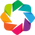

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

In [1]:
# Load necessary libraries
import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from importlib import resources
import subprocess
from Bio import SeqIO
import tqdm
import re
import gzip
import shutil

# Add the path to the levseq directory to the system path
sys.path.append('../levseq')

# Import custom functions from the provided script
from run_levseq import *
result_folder = os.getcwd()

## 2. Define Run Location
We'll specify the location of the sequencing run data. This is also within the same directory structure.


In [2]:
# Define the path to the run data
run_location = '/Users/JLoong8/git/LevSeq/example/sample_data/parlq_ep1'
ref_df = pd.read_csv('/Users/JLoong8/git/LevSeq/example/sample_data/parlq_ep1/20240422-YL-ParLQ-ep1.csv')
name = 'Test-ep1'

## 3. Demultiplexing and variant calling
Demultiplexing is the process of separating out individual samples from a multiplexed sequencing run. We'll use the `demux_fastq` function from the custom script to perform this step.


In [16]:
# Create empty variant df
result_folder = os.path.join(result_folder, name)
variant_df = pd.DataFrame(columns=["barcode_plate", "name", "refseq", "variant"])

for i, row in ref_df.iterrows():
    barcode_plate = row["barcode_plate"]
    name = row["name"]
    refseq = row["refseq"].upper()

    # Create a subfolder for the current iteration using the name value
    name_folder = os.path.join(result_folder, name)
    os.makedirs(name_folder, exist_ok=True)

    # Write the refseq to a temporary fasta file
    temp_fasta_path = os.path.join(name_folder, f"temp_{name}.fasta")
    with open(temp_fasta_path, "w") as f:
        f.write(f">{name}\n{refseq}\n")
    # Create filtered barcode path
    f_min = 1
    f_max = 96
    rbc = i+1
    front_prefix = "NB"
    back_prefix = "RB"
    barcode_path = "../levseq/barcoding/minion_barcodes.fasta"
    barcode_path_filter = os.path.join(name_folder, "minion_barcodes_filtered.fasta")
    filter_barcodes(
        barcode_path,
        barcode_path_filter,
        (f_min, f_max),
        rbc,
        front_prefix,
        back_prefix,)
    
    # Perform demultiplexing
    demux_fastq(run_location, name_folder, barcode_path_filter)
    
    variant_result = call_variant(f"{name}", name_folder, temp_fasta_path, barcode_path_filter)
    variant_result["barcode_plate"] = barcode_plate
    variant_result["name"] = name
    variant_result["refseq"] = refseq
    variant_df = pd.concat([variant_df, variant_result])
variant_df.to_csv(variant_csv_path, index=False)

Processed argument: -f with value: /Users/JLoong8/git/LevSeq/example/sample_data/parlq_ep1
Processed argument: -d with value: /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1
Processed argument: -b with value: /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/minion_barcodes_filtered.fasta
Processed argument: -w with value: 100
Processed argument: -r with value: 100
Processed argument: -m with value: 800
Processed argument: -x with value: 5000
Number of files: 2
Processing files: [#########################                         ] 50%


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

  0%|                                                                                              | 0/9 [00:00<?, ?it/s]





Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB10
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB02
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB19


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]






Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB37
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB28


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]





  0%|                                                                                              | 0/9 [00:00<?, ?it/s]








Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB55
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB03
Writing MSA
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB46


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

Writing MSA


Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB64


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]








  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB73
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB82
Writing MSA
Writing MSA
Writing MSA



 11%|█████████▌                                                                            | 1/9 [00:01<00:12,  1.56s/it]


 11%|█████████▌                                                                            | 1/9 [00:01<00:12,  1.57s/it]




 11%|█████████▌                                                                            | 1/9 [00:01<00:12,  1.57s/it]



 11%|█████████▌                                                                            | 1/9 [00:01<00:13,  1.74s/it]






 11%|█████████▌                                                                            | 1/9 [00:01<00:11,  1.43s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB20
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB29
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB56
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB38
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB11
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB65




 33%|████████████████████████████▋                                                         | 3/9 [00:01<00:03,  1.53it/s]







 11%|█████████▌                                                                            | 1/9 [00:01<00:12,  1.57s/it]








 11%|█████████▌                                                                            | 1/9 [00:01<00:12,  1.61s/it]





 11%|█████████▌                                                                            | 1/9 [00:01<00:15,  1.89s/it]

Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB04
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB74
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB83
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB47
Writing MSA
Writing MSA
Writing MSA



 22%|███████████████████                                                                   | 2/9 [00:03<00:11,  1.69s/it]







 22%|███████████████████                                                                   | 2/9 [00:03<00:10,  1.52s/it]






 22%|███████████████████                                                                   | 2/9 [00:03<00:11,  1.61s/it]

 44%|██████████████████████████████████████▏                                               | 4/9 [00:03<00:04,  1.08it/s]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB12
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB21
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB75
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB66
Writing MSA





 33%|████████████████████████████▋                                                         | 3/9 [00:03<00:05,  1.02it/s]




 22%|███████████████████                                                                   | 2/9 [00:03<00:12,  1.75s/it]





 22%|███████████████████                                                                   | 2/9 [00:03<00:11,  1.64s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB05
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB30
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB13
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB57
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB48






 22%|███████████████████                                                                   | 2/9 [00:03<00:12,  1.84s/it]








 22%|███████████████████                                                                   | 2/9 [00:03<00:11,  1.60s/it]

Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB39
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB84
Writing MSA
Writing MSA










 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:10,  1.83s/it]




 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:10,  1.75s/it]






 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:10,  1.71s/it]


 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:10,  1.79s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB76
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB22
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB58
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB67
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB31






 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:10,  1.77s/it]

 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:05<00:05,  1.27s/it]




 44%|██████████████████████████████████████▏                                               | 4/9 [00:05<00:07,  1.40s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB40
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB06
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB59
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB14


Writing MSA
Writing MSA
Writing MSA


 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:11,  1.99s/it]








 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:11,  1.93s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB49
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB85
Writing MSA





 44%|██████████████████████████████████████▏                                               | 4/9 [00:06<00:08,  1.70s/it]

Writing MSA









 44%|██████████████████████████████████████▏                                               | 4/9 [00:06<00:08,  1.68s/it]



 44%|██████████████████████████████████████▏                                               | 4/9 [00:07<00:08,  1.79s/it]







 44%|██████████████████████████████████████▏                                               | 4/9 [00:06<00:08,  1.73s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB32
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB68
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB41
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB23
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB77
Writing MSA
Writing MSA







 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:07<00:06,  1.64s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB60




 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:07<00:04,  1.57s/it]








 44%|██████████████████████████████████████▏                                               | 4/9 [00:07<00:09,  1.93s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB15
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB07
Writing MSA
Writing MSA
Writing MSA


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB86








 44%|██████████████████████████████████████▏                                               | 4/9 [00:08<00:10,  2.19s/it]

Writing MSA





 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:08<00:06,  1.68s/it]






 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:08<00:06,  1.67s/it]



 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:08<00:06,  1.73s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB50
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB33
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB69
Writing MSA










 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:08<00:06,  1.71s/it]




 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:09<00:04,  1.52s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB42
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB78
Writing MSA



 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:09<00:07,  1.98s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB61
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB24
Writing MSA




 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:09<00:05,  1.75s/it]

 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:09<00:01,  1.22s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB08Writing MSA

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB16
Writing MSA
Writing MSA


 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:09<00:02,  1.27s/it]








 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:09<00:07,  1.94s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB17Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB09

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB87
Writing MSA
Writing MSA
Writing MSA





 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:10<00:05,  1.76s/it]






 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:10<00:05,  1.74s/it]







 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:10<00:05,  1.74s/it]





 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:10<00:08,  2.16s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB34
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB70
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB79
Writing MSA






 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:10<00:05,  1.83s/it]




 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:10<00:03,  1.57s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB51
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB43
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB62
Writing MSA
Writing MSA



 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:11<00:06,  2.07s/it]

 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:11<00:01,  1.43s/it]








100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.32s/it]


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB25
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB18
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB88
Writing MSA



  0%|                                                                                              | 0/6 [00:00<?, ?it/s]






 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:11<00:03,  1.68s/it]








Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB91
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB71


 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:11<00:05,  1.93s/it]


 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:12<00:03,  1.76s/it]







 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:11<00:03,  1.75s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB52
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB35
Writing MSA
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB80
Writing MSA







 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:12<00:01,  1.74s/it]



 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:13<00:03,  1.96s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB63
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB44



 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:13<00:04,  2.01s/it]








100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.57s/it]






 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:13<00:01,  1.64s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB26
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB89
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB72
Writing MSA








 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:13<00:03,  1.80s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.55s/it]








 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:13<00:01,  1.73s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB53
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB36




 17%|██████████████▎                                                                       | 1/6 [00:02<00:11,  2.23s/it]

Writing MSAAligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB81

Writing MSA
Writing MSA







100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.67s/it]

 33%|████████████████████████████▋                                                         | 2/6 [00:02<00:04,  1.09s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB92
Writing MSA


100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.62s/it]


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB93
Writing MSA



 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:15<00:01,  1.85s/it]



 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:15<00:01,  1.98s/it]








 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:14<00:01,  1.77s/it]






100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.66s/it]


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB27
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB45
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB90
Writing MSA
Writing MSA








 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:15<00:01,  1.82s/it]




Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB54


100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.71s/it]







100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.74s/it]


Writing MSA




 50%|███████████████████████████████████████████                                           | 3/6 [00:03<00:03,  1.24s/it]








100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.59s/it]



100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.66s/it]





100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.76s/it]


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB94
Writing MSA




 67%|█████████████████████████████████████████████████████████▎                            | 4/6 [00:04<00:01,  1.16it/s]

 83%|███████████████████████████████████████████████████████████████████████▋              | 5/6 [00:04<00:00,  1.64it/s]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB95
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-1/RB01/NB96




100%|██████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.31it/s]


Writing MSA
Processed argument: -f with value: /Users/JLoong8/git/LevSeq/example/sample_data/parlq_ep1
Processed argument: -d with value: /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2
Processed argument: -b with value: /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/minion_barcodes_filtered.fasta
Processed argument: -w with value: 100
Processed argument: -r with value: 100
Processed argument: -m with value: 800
Processed argument: -x with value: 5000
Number of files: 2
Processing files: [#########################                         ] 50%


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB10



  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

  0%|                                                                                              | 0/9 [00:00<?, ?it/s]


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]




  0%|                                                                                              | 0/9 [00:00<?, ?it/s]



  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB19
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB02
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB28
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB46
Writing MSA
Writing MSA
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB37








  0%|                                                                                              | 0/9 [00:00<?, ?it/s]








Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB55


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]







  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB64
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB73
Writing MSA











  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB82
Writing MSA



 11%|█████████▌                                                                            | 1/9 [00:01<00:12,  1.58s/it]




 11%|█████████▌                                                                            | 1/9 [00:01<00:13,  1.67s/it]





 11%|█████████▌                                                                            | 1/9 [00:01<00:13,  1.74s/it]


 11%|█████████▌                                                                            | 1/9 [00:01<00:13,  1.74s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB20
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB47
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB56
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB11
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB29






 11%|█████████▌                                                                            | 1/9 [00:01<00:13,  1.74s/it]






 11%|█████████▌                                                                            | 1/9 [00:01<00:12,  1.58s/it]

 22%|███████████████████                                                                   | 2/9 [00:02<00:06,  1.05it/s]

Writing MSA
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB38
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB65
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB03
Writing MSA











 11%|█████████▌                                                                            | 1/9 [00:01<00:12,  1.53s/it]







 11%|█████████▌                                                                            | 1/9 [00:01<00:14,  1.87s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB83
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB74
Writing MSA
Writing MSA



 22%|███████████████████                                                                   | 2/9 [00:03<00:11,  1.71s/it]


 22%|███████████████████                                                                   | 2/9 [00:03<00:12,  1.78s/it]






 22%|███████████████████                                                                   | 2/9 [00:03<00:11,  1.67s/it]







 22%|███████████████████                                                                   | 2/9 [00:03<00:11,  1.58s/it]




 22%|███████████████████                                                                   | 2/9 [00:03<00:12,  1.82s/it]







Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB21
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB30
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB66
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB75
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB48


 22%|███████████████████                                                                   | 2/9 [00:03<00:12,  1.77s/it]



 22%|███████████████████                                                                   | 2/9 [00:03<00:12,  1.81s/it]










Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB57
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB39


 22%|███████████████████                                                                   | 2/9 [00:04<00:14,  2.13s/it]

 33%|████████████████████████████▋                                                         | 3/9 [00:04<00:09,  1.51s/it]

Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB84
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB12
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB04
Writing MSA
Writing MSA
Writing MSA










 33%|████████████████████████████▋                                                         | 3/9 [00:04<00:09,  1.62s/it]






 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:10,  1.71s/it]





 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:10,  1.78s/it]


 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:11,  1.90s/it]


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB76
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB67
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB58
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB31


 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:11,  1.95s/it]



 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:11,  1.87s/it]








 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:10,  1.75s/it]





 44%|██████████████████████████████████████▏                                               | 4/9 [00:05<00:05,  1.18s/it]

Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB22
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB40
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB13
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB85
Writing MSA







 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:11,  1.98s/it]

Writing MSAAligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB59

Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB49
Writing MSA




 44%|██████████████████████████████████████▏                                               | 4/9 [00:06<00:08,  1.75s/it]




 44%|██████████████████████████████████████▏                                               | 4/9 [00:06<00:07,  1.44s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB05
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB50







 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:06<00:04,  1.02s/it]

Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB51
Writing MSA









 44%|██████████████████████████████████████▏                                               | 4/9 [00:07<00:08,  1.78s/it]







 44%|██████████████████████████████████████▏                                               | 4/9 [00:07<00:08,  1.78s/it]


 44%|██████████████████████████████████████▏                                               | 4/9 [00:07<00:09,  1.85s/it]





 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:07<00:05,  1.37s/it]








 44%|██████████████████████████████████████▏                                               | 4/9 [00:06<00:08,  1.77s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB68
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB77
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB32
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB60






 44%|██████████████████████████████████████▏                                               | 4/9 [00:07<00:09,  1.99s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB86
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB41
Writing MSA


Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB23
Writing MSA


 44%|██████████████████████████████████████▏                                               | 4/9 [00:08<00:10,  2.10s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB14
Writing MSA


Writing MSA


 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:08<00:03,  1.33s/it]

 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:08<00:08,  2.01s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB52
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB06
Writing MSA









 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:08<00:07,  1.79s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB69





 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:09<00:07,  1.92s/it]






 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:09<00:04,  1.35s/it]



 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:09<00:07,  1.96s/it]







Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB33
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB70
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB42


 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:09<00:05,  1.67s/it]







 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:09<00:07,  2.00s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB61
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB78











 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:09<00:08,  2.03s/it]

Writing MSA
Writing MSA



 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:10<00:08,  2.14s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB87
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB24
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB15
Writing MSA
Writing MSA
Writing MSA







 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:10<00:03,  1.61s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB53





 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:11<00:05,  1.91s/it]

Writing MSA




 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:11<00:06,  2.17s/it]






 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:11<00:03,  1.51s/it]







 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:11<00:05,  1.89s/it]





 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:11<00:03,  1.68s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB34
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB07
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB71
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB79






 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:11<00:05,  1.92s/it]








 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:11<00:05,  1.91s/it]







 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:11<00:02,  1.40s/it]

Writing MSAAligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB62

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB43
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB88
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB80



 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:12<00:06,  2.06s/it]

Writing MSA
Writing MSA
Writing MSA


 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:12<00:06,  2.15s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB25
Writing MSA


 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:12<00:03,  1.53s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB16
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB17







 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:12<00:01,  1.77s/it]


 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:13<00:03,  1.89s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB54
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB35










 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:13<00:01,  1.49s/it]

Writing MSA
Writing MSA




 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:13<00:04,  2.15s/it]





 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:13<00:01,  1.81s/it]






 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:13<00:01,  1.71s/it]








 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:13<00:03,  1.91s/it]



 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:13<00:04,  2.03s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB81
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB08
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB63
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB72
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB89
Writing MSA




 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:13<00:01,  1.59s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB44
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB09
Writing MSA


Writing MSA


 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:14<00:01,  1.63s/it]




100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.64s/it]


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB26
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB18
Writing MSA







  0%|                                                                                              | 0/6 [00:00<?, ?it/s]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB91








100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.76s/it]


 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:15<00:01,  1.94s/it]








Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB36


100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.76s/it]








100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.71s/it]








100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.66s/it]



 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:15<00:01,  1.97s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.72s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB90
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB45
Writing MSA
Writing MSA



100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.77s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.82s/it]


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB27
Writing MSA







 17%|██████████████▎                                                                       | 1/6 [00:01<00:07,  1.57s/it]








100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.65s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.77s/it]



100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.79s/it]





100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.86s/it]


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB92
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB93







 50%|███████████████████████████████████████████                                           | 3/6 [00:01<00:01,  1.93it/s]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB94







 67%|█████████████████████████████████████████████████████████▎                            | 4/6 [00:02<00:00,  2.51it/s]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB95
Writing MSA







 83%|███████████████████████████████████████████████████████████████████████▋              | 5/6 [00:02<00:00,  3.14it/s]




100%|██████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.34it/s]


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/300-2/RB02/NB96
Writing MSA
Processed argument: -f with value: /Users/JLoong8/git/LevSeq/example/sample_data/parlq_ep1
Processed argument: -d with value: /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1
Processed argument: -b with value: /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/minion_barcodes_filtered.fasta
Processed argument: -w with value: 100
Processed argument: -r with value: 100
Processed argument: -m with value: 800
Processed argument: -x with value: 5000
Number of files: 2
Processing files: [#########################                         ] 50%


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

  0%|                                                                                              | 0/9 [00:00<?, ?it/s]


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB10
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB01
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB19






  0%|                                                                                              | 0/9 [00:00<?, ?it/s]




  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB28
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB37


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB46
Writing MSA
Writing MSA
Writing MSA


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]



Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB55


 11%|█████████▌                                                                            | 1/9 [00:00<00:01,  7.60it/s]







  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB02Writing MSA



Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB73


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]










Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB64
Writing MSA


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB82
Writing MSA
Writing MSA





 11%|█████████▌                                                                            | 1/9 [00:01<00:14,  1.77s/it]

 11%|█████████▌                                                                            | 1/9 [00:01<00:14,  1.82s/it]




 11%|█████████▌                                                                            | 1/9 [00:01<00:13,  1.72s/it]









Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB29
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB20
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB03
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB11
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB47
Writing MSA
Writing MSA


 11%|█████████▌                                                                            | 1/9 [00:01<00:11,  1.48s/it]



 11%|█████████▌                                                                            | 1/9 [00:02<00:14,  1.83s/it]





 11%|█████████▌                                                                            | 1/9 [00:02<00:13,  1.67s/it]






 11%|█████████▌                                                                            | 1/9 [00:01<00:11,  1.46s/it]










Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB74
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB38
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB56
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB65


 11%|█████████▌                                                                            | 1/9 [00:01<00:11,  1.43s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB83
Writing MSA
Writing MSA



 22%|███████████████████                                                                   | 2/9 [00:03<00:11,  1.71s/it]

 33%|████████████████████████████▋                                                         | 3/9 [00:03<00:08,  1.41s/it]




 22%|███████████████████                                                                   | 2/9 [00:03<00:12,  1.82s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB21
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB04










 22%|███████████████████                                                                   | 2/9 [00:03<00:12,  1.72s/it]


 22%|███████████████████                                                                   | 2/9 [00:03<00:13,  1.88s/it]






 22%|███████████████████                                                                   | 2/9 [00:03<00:12,  1.74s/it]








 22%|███████████████████                                                                   | 2/9 [00:03<00:11,  1.64s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB48
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB75
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB30
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB12
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB66
Writing MSA
Writing MSA
Writing MSA
Writing MSA




 44%|██████████████████████████████████████▏                                               | 4/9 [00:04<00:04,  1.04it/s]





 22%|███████████████████                                                                   | 2/9 [00:04<00:13,  1.89s/it]



 22%|███████████████████                                                                   | 2/9 [00:04<00:13,  1.99s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB84
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB05
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB57
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB39
Writing MSA
Writing MSA
Writing MSA



 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:10,  1.78s/it]


 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:10,  1.79s/it]







 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:10,  1.82s/it]




 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:11,  1.87s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB22
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB31
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB76
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB13
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB49








 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:10,  1.82s/it]






 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:11,  1.86s/it]





 44%|██████████████████████████████████████▏                                               | 4/9 [00:05<00:06,  1.22s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB58
Writing MSA
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB67
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB59
Writing MSA
Writing MSA











 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:12,  2.06s/it]



 33%|████████████████████████████▋                                                         | 3/9 [00:06<00:13,  2.23s/it]

 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:06<00:06,  1.55s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB85
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB40
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB06
Writing MSA
Writing MSA
Writing MSA





 44%|██████████████████████████████████████▏                                               | 4/9 [00:07<00:08,  1.79s/it]







 44%|██████████████████████████████████████▏                                               | 4/9 [00:07<00:09,  1.88s/it]






 44%|██████████████████████████████████████▏                                               | 4/9 [00:07<00:08,  1.73s/it]







Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB32
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB77
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB23
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB68
Writing MSA


 44%|██████████████████████████████████████▏                                               | 4/9 [00:07<00:09,  1.91s/it]




 44%|██████████████████████████████████████▏                                               | 4/9 [00:07<00:09,  1.92s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB60Writing MSA

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB14
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB50
Writing MSA
Writing MSA
Writing MSA






 44%|██████████████████████████████████████▏                                               | 4/9 [00:08<00:10,  2.05s/it]








 44%|██████████████████████████████████████▏                                               | 4/9 [00:07<00:09,  1.99s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB41
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB86
Writing MSA
Writing MSA




 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:09<00:05,  1.86s/it]


 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:09<00:07,  1.88s/it]






 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:08<00:07,  1.77s/it]

 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:09<00:02,  1.35s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB07
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB33
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB69



 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:09<00:07,  1.94s/it]







 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:09<00:07,  1.92s/it]




 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:09<00:07,  1.92s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB08
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB24
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB78
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB51
Writing MSA
Writing MSA
Writing MSA


 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:09<00:08,  2.08s/it]





 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:09<00:05,  1.73s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB15
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB61
Writing MSA


Writing MSA


 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:10<00:08,  2.14s/it]








 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:10<00:08,  2.13s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB42
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB87
Writing MSA





 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:10<00:05,  1.82s/it]




 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:11<00:05,  1.81s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB34









 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:11<00:05,  1.91s/it]

 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:11<00:01,  1.54s/it]









Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB52
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB70
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB25
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB09


 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:11<00:05,  1.88s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB79
Writing MSA
Writing MSA








 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:12<00:02,  1.49s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB62
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB16
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB17
Writing MSA






 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:12<00:06,  2.13s/it]








 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:12<00:06,  2.08s/it]




 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:12<00:03,  1.78s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB43
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB88
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB53



 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:13<00:03,  1.90s/it]







 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:12<00:03,  1.87s/it]

Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB26





 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:13<00:03,  1.94s/it]






 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:12<00:03,  1.92s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.50s/it]


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB80
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB35
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB71
Writing MSA
Writing MSA




  0%|                                                                                              | 0/6 [00:00<?, ?it/s]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB91








100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.52s/it]


Writing MSA


 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:14<00:01,  1.64s/it]








 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:13<00:03,  1.97s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB18
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB89






 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:14<00:04,  2.07s/it]




 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:14<00:01,  1.76s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB44
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB54
Writing MSA










 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:15<00:01,  1.91s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB81Writing MSA

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB27
Writing MSA









 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:14<00:01,  1.94s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB72





 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:15<00:02,  2.07s/it]

 17%|██████████████▎                                                                       | 1/6 [00:01<00:09,  1.86s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB36
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB92
Writing MSA




 33%|████████████████████████████▋                                                         | 2/6 [00:02<00:03,  1.07it/s]

Writing MSA











100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.80s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB93
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB90
Writing MSA








100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.78s/it]

Writing MSA






100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.83s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.86s/it]


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB45
Writing MSA










100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.88s/it]






100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.85s/it]



100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:17<00:00,  1.91s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:17<00:00,  1.90s/it]









100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.60s/it]



100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:17<00:00,  1.90s/it]


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB94
Writing MSA




 67%|█████████████████████████████████████████████████████████▎                            | 4/6 [00:03<00:01,  1.35it/s]

 83%|███████████████████████████████████████████████████████████████████████▋              | 5/6 [00:03<00:00,  1.85it/s]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB95
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-1/RB03/NB96




100%|██████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.50it/s]

Writing MSA
Processed argument: -f with value: /Users/JLoong8/git/LevSeq/example/sample_data/parlq_ep1
Processed argument: -d with value: /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2
Processed argument: -b with value: /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/minion_barcodes_filtered.fasta
Processed argument: -w with value: 100
Processed argument: -r with value: 100
Processed argument: -m with value: 800
Processed argument: -x with value: 5000


Number of files: 2
Processing files: [#########################                         ] 50%


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB10




  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB03
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB19






  0%|                                                                                              | 0/9 [00:00<?, ?it/s]


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]







Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB37
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB28
Writing MSA


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]




  0%|                                                                                              | 0/9 [00:00<?, ?it/s]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB55
Writing MSA









  0%|                                                                                              | 0/9 [00:00<?, ?it/s]








  0%|                                                                                              | 0/9 [00:00<?, ?it/s]









Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB46
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB64
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB82


  0%|                                                                                              | 0/9 [00:00<?, ?it/s]


 11%|█████████▌                                                                            | 1/9 [00:00<00:01,  6.28it/s]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB73
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB29
Writing MSA
Writing MSA







 11%|█████████▌                                                                            | 1/9 [00:01<00:10,  1.31s/it]








 11%|█████████▌                                                                            | 1/9 [00:01<00:10,  1.30s/it]

 11%|█████████▌                                                                            | 1/9 [00:01<00:13,  1.68s/it]



 11%|█████████▌                                                                            | 1/9 [00:01<00:13,  1.65s/it]







Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB47
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB83
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB04
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB20
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB38


 11%|█████████▌                                                                            | 1/9 [00:01<00:13,  1.70s/it]


 22%|███████████████████                                                                   | 2/9 [00:01<00:06,  1.06it/s]






 11%|█████████▌                                                                            | 1/9 [00:01<00:12,  1.55s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB56
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB11
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB30
Writing MSA
Writing MSA










 11%|█████████▌                                                                            | 1/9 [00:01<00:11,  1.50s/it]






 22%|███████████████████                                                                   | 2/9 [00:02<00:06,  1.06it/s]









Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB65
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB74
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB66


 22%|███████████████████                                                                   | 2/9 [00:01<00:05,  1.18it/s]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB75
Writing MSA










 33%|████████████████████████████▋                                                         | 3/9 [00:02<00:03,  1.55it/s]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB76







 22%|███████████████████                                                                   | 2/9 [00:02<00:10,  1.48s/it]

Writing MSA











 22%|███████████████████                                                                   | 2/9 [00:03<00:10,  1.50s/it]

 22%|███████████████████                                                                   | 2/9 [00:03<00:12,  1.74s/it]



 22%|███████████████████                                                                   | 2/9 [00:03<00:12,  1.76s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB48
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB84
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB05
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB21
Writing MSA
Writing MSA





 22%|███████████████████                                                                   | 2/9 [00:03<00:13,  1.94s/it]


 44%|██████████████████████████████████████▏                                               | 4/9 [00:03<00:04,  1.05it/s]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB39
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB31
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB22
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB12
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB32


 33%|████████████████████████████▋                                                         | 3/9 [00:03<00:06,  1.13s/it]





 22%|███████████████████                                                                   | 2/9 [00:03<00:14,  2.01s/it]






 33%|████████████████████████████▋                                                         | 3/9 [00:03<00:07,  1.33s/it]

Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB13
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB57
Writing MSA








 33%|████████████████████████████▋                                                         | 3/9 [00:04<00:07,  1.20s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB67
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB58








 44%|██████████████████████████████████████▏                                               | 4/9 [00:04<00:04,  1.20it/s]







 44%|██████████████████████████████████████▏                                               | 4/9 [00:04<00:05,  1.12s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB59
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB77
Writing MSA
Writing MSA











 33%|████████████████████████████▋                                                         | 3/9 [00:04<00:09,  1.67s/it]



 33%|████████████████████████████▋                                                         | 3/9 [00:05<00:10,  1.71s/it]




 44%|██████████████████████████████████████▏                                               | 4/9 [00:05<00:06,  1.27s/it]




Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB85
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB40
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB49
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB23


 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:05<00:04,  1.13s/it]

 44%|██████████████████████████████████████▏                                               | 4/9 [00:05<00:06,  1.26s/it]






 44%|██████████████████████████████████████▏                                               | 4/9 [00:05<00:06,  1.36s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB33
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB06
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB14
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB68
Writing MSA
Writing MSA








 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:06<00:04,  1.10s/it]







 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:05<00:05,  1.32s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB60
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB78
Writing MSA











 44%|██████████████████████████████████████▏                                               | 4/9 [00:06<00:08,  1.74s/it]






 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:06<00:05,  1.43s/it]



 44%|██████████████████████████████████████▏                                               | 4/9 [00:07<00:09,  1.83s/it]




 44%|██████████████████████████████████████▏                                               | 4/9 [00:07<00:09,  1.84s/it]


 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:07<00:04,  1.38s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB86
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB69
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB41
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB50
Writing MSA


 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:07<00:05,  1.46s/it]

 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:07<00:06,  1.55s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB34Writing MSA

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB15
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB07
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB24
Writing MSA


Writing MSA
Writing MSA


 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:07<00:03,  1.27s/it]









Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB61
Writing MSA


 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:07<00:04,  1.50s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB79











 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:08<00:07,  1.77s/it]

Writing MSA







 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:08<00:07,  1.77s/it]






 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:08<00:04,  1.54s/it]

 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:09<00:04,  1.55s/it]



 56%|███████████████████████████████████████████████▊                                      | 5/9 [00:09<00:07,  1.82s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB87
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB51
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB70
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB08
Writing MSA



 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:09<00:02,  1.09s/it]


 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:09<00:03,  1.57s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB42
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB25
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB17
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB35
Writing MSA
Writing MSA
Writing MSA










 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:09<00:03,  1.51s/it]





 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:09<00:03,  1.53s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB80
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB62
Writing MSA
Writing MSA







 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:10<00:05,  1.70s/it]



 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:10<00:05,  1.76s/it]








 67%|█████████████████████████████████████████████████████████▎                            | 6/9 [00:10<00:05,  1.79s/it]






 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:10<00:03,  1.63s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB52
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB43
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB88
Writing MSA



 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:10<00:01,  1.25s/it]

 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:10<00:01,  1.62s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB71
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB26
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB18
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB09
Writing MSA
Writing MSA
Writing MSA





 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:11<00:01,  1.74s/it]

Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB36










 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:10<00:01,  1.54s/it]





 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:11<00:01,  1.63s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB81
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB63
Writing MSA
Writing MSA








100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.18s/it]




100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.34s/it]









 78%|██████████████████████████████████████████████████████████████████▉                   | 7/9 [00:11<00:03,  1.71s/it]



 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:12<00:01,  1.62s/it]








Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB53
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB89
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB44
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB27


 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:12<00:01,  1.67s/it]





100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.40s/it]


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB72
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB91
Writing MSA




100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.43s/it]


Writing MSA





100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.45s/it]








100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.41s/it]





 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:13<00:01,  1.58s/it]








 89%|████████████████████████████████████████████████████████████████████████████▍         | 8/9 [00:13<00:01,  1.56s/it]






100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.47s/it]




100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.49s/it]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB54
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB90
Writing MSA
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB45








100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.52s/it]


Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB93
Writing MSA
Writing MSA







100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.31s/it]



100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.28s/it]








100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.30s/it]





100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.54s/it]








Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB94
Writing MSA


 67%|█████████████████████████████████████████████████████████▎                            | 4/6 [00:01<00:00,  2.53it/s]





 83%|███████████████████████████████████████████████████████████████████████▋              | 5/6 [00:02<00:00,  3.14it/s]

Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB95
Writing MSA
Aligning sequences for /Users/JLoong8/git/LevSeq/example/Test-ep1/500-2/500-2/RB04/NB96








100%|██████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.77it/s]

Writing MSA


NameError: name 'variant_csv_path' is not defined

## 4. Create variant and visualization csv files

In [29]:
variant_df

,barcode_plate,name,refseq,variant,index,Plate,Well,Barcode,ID,P value,Mixed Well,Variant,Average mutation frequency,Alignment Count,P adj. value
0,1,300-1,ATGGCGGTTCCCGGCTACGATTTTGGCAAAGTCCCGGATGCCCCAA...,NaN,0.0,300-1,A1,RB01_NB01,300-1_A1,1.000000e+00,None,None,NaN,NaN,1.000000e+00
1,1,300-1,ATGGCGGTTCCCGGCTACGATTTTGGCAAAGTCCCGGATGCCCCAA...,NaN,1.0,300-1,A2,RB01_NB02,300-1_A2,1.000000e+00,None,None,NaN,0.0,1.000000e+00
2,1,300-1,ATGGCGGTTCCCGGCTACGATTTTGGCAAAGTCCCGGATGCCCCAA...,NaN,2.0,300-1,A3,RB01_NB03,300-1_A3,1.000000e+00,False,T62G_G273A_A284G,0.935897,78.0,1.000000e+00
3,1,300-1,ATGGCGGTTCCCGGCTACGATTTTGGCAAAGTCCCGGATGCCCCAA...,NaN,3.0,300-1,A4,RB01_NB04,300-1_A4,NaN,False,#PARENT#,NaN,22.0,NaN
4,1,300-1,ATGGCGGTTCCCGGCTACGATTTTGGCAAAGTCCCGGATGCCCCAA...,NaN,4.0,300-1,A5,RB01_NB05,300-1_A5,NaN,False,#PARENT#,NaN,89.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,4,500-2,ATGGCGGTTCCCGGCTACGATTTTGGCAAAGTCCCGGATGCCCCAA...,NaN,91.0,500-2,H8,RB04_NB92,500-2_H8,1.000000e+00,None,None,NaN,NaN,1.000000e+00
92,4,500-2,ATGGCGGTTCCCGGCTACGATTTTGGCAAAGTCCCGGATGCCCCAA...,NaN,92.0,500-2,H9,RB04_NB93,500-2_H9,1.740075e-43,True,C378T_T422C_T446DEL,0.822222,15.0,1.670472e-41
93,4,500-2,ATGGCGGTTCCCGGCTACGATTTTGGCAAAGTCCCGGATGCCCCAA...,NaN,93.0,500-2,H10,RB04_NB94,500-2_H10,5.367269e-117,False,G246DEL_T417C,0.937500,40.0,5.152578e-115
94,4,500-2,ATGGCGGTTCCCGGCTACGATTTTGGCAAAGTCCCGGATGCCCCAA...,NaN,94.0,500-2,H11,RB04_NB95,500-2_H11,3.079761e-35,False,T281C,1.000000,23.0,2.956571e-33


## 5. Visualization
Finally, we'll visualize the results using appropriate visualization functions. This step helps in understanding the distribution and impact of the identified variants.

In [30]:
df_variants, df_vis = create_df_v(variant_df)
layout = generate_platemaps(
            max_combo_data=df_vis,
            result_folder=result_folder,)   
layout

:HoloMap   [Plate]
   :Overlay
      .HeatMap.I :HeatMap   [Column,Row]   (logseqdepth,Mutations,Alignment Count,Alignment Probability)
      .Points.I  :Points   [Column,Row]   (AlignmentProbabilityBinned)
      .Labels.I  :Labels   [Column,Row]   (Labels)